## Import TensorFlow and other libraries

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

## Mount Google Drive to gain access to datasets

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


This tutorial uses a dataset of about 1,001 photos of cracks. The dataset contains four sub-directories, one per class:

```
cracks_photo/
  negative/
  small/
  medium/
  severe/
```

In [3]:
import pathlib
data_dir = "/content/drive/My Drive/class_test/datasets"
data_dir = pathlib.Path(data_dir)

After enable access, there are 1,001 total images:

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1001


Here are some negative cracks:

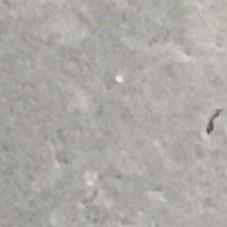

In [5]:
negative = list(data_dir.glob('0-negative/*'))
PIL.Image.open(str(negative[0]))

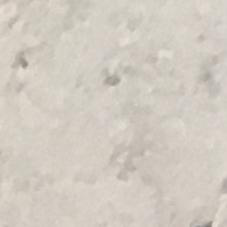

In [6]:
PIL.Image.open(str(negative[1]))

And some medium-cracks:

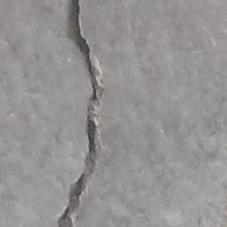

In [7]:
positive = list(data_dir.glob('2-medium/*'))
PIL.Image.open(str(positive[0]))

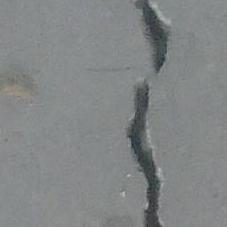

In [8]:
PIL.Image.open(str(positive[1]))

# Load data using a Keras utility

> Indented block



Let's load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code.

## Create a dataset

Define some parameters for the loader:

In [9]:
batch_size = 32
img_height = 227
img_width = 227

It's good practice to use a validation split when developing your model. Let's use 80% of the images for training, and 20% for validation.

In [10]:
# Train_data
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1001 files belonging to 4 classes.
Using 801 files for training.


In [11]:
# Val_data
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1001 files belonging to 4 classes.
Using 200 files for validation.


You can find the class names in the class_names attribute on these datasets. These correspond to the directory names in alphabetical order.

In [12]:
class_names = train_ds.class_names
print(class_names)

['0-negative', '1-small', '2-medium', '3-severe']


## Visualize the data

Here are the first nine images from the training dataset:

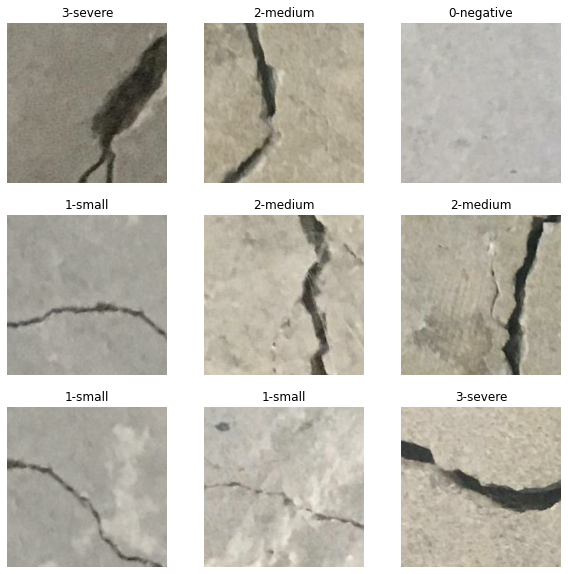

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You will train a model using these datasets by passing them to Model.fit in a moment. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 227, 227, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 227, 227, 3)`. This is a batch of 32 images of shape `227x227x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.

## Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Create the model

The [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned for high accuracy—the goal of this tutorial is to show a standard approach.

In [16]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])



```
# This is formatted as code
```

## Compile the model

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model summary

View all the layers of the network using the model's `Model.summary` method:

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 227, 227, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 227, 227, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 113, 113, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 113, 113, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        1

## Train the model

In [19]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
26/26 [==============================] - 162s 3s/step - loss: 1.6046 - accuracy: 0.2297 - val_loss: 1.3681 - val_accuracy: 0.4400
Epoch 2/10
26/26 [==============================] - 27s 1s/step - loss: 1.2758 - accuracy: 0.4444 - val_loss: 1.1915 - val_accuracy: 0.4900
Epoch 3/10
26/26 [==============================] - 26s 1s/step - loss: 0.9915 - accuracy: 0.6429 - val_loss: 0.8406 - val_accuracy: 0.6550
Epoch 4/10
26/26 [==============================] - 26s 1s/step - loss: 0.7330 - accuracy: 0.7328 - val_loss: 0.8934 - val_accuracy: 0.6500
Epoch 5/10
26/26 [==============================] - 27s 1s/step - loss: 0.5418 - accuracy: 0.7890 - val_loss: 0.6928 - val_accuracy: 0.6950
Epoch 6/10
26/26 [==============================] - 28s 1s/step - loss: 0.3884 - accuracy: 0.8352 - val_loss: 0.9116 - val_accuracy: 0.7350
Epoch 7/10
26/26 [==============================] - 26s 1s/step - loss: 0.3532 - accuracy: 0.8564 - val_loss: 0.5465 - val_accuracy: 0.8100
Epoch 8/10
26/26 [=

## Visualize training results

Create plots of loss and accuracy on the training and validation sets:

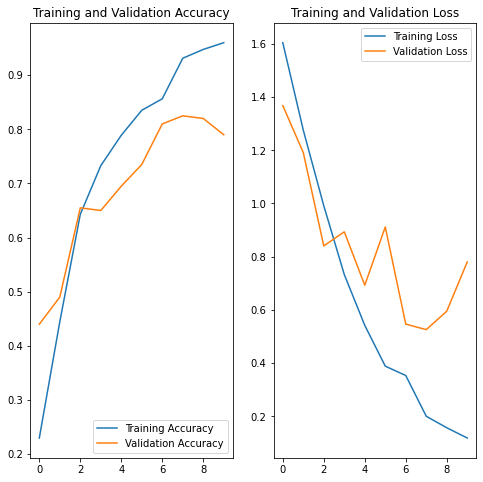

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Test Model

In [21]:
test_path = "/content/drive/My Drive/class_test/test/00307.jpg"

img = tf.keras.utils.load_img(
    test_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to 2-medium with a 95.68 percent confidence.


## Save the model in .h5 file

In [ ]:
model.save_weights('/content/drive/My Drive/keras_model/model_weights.h5')
model.save('/content/drive/My Drive/keras_model/model.h5')

print(model.save)